# Validity of using prescription records to identify patient comorbidities
## Combined Analysis of Ashtma

**ReadMe:**
- This is a script used in the analysis for Schnier et al., 2025: Validity of using prescription records to classify disease – a record linkage study using routinely collected electronic health records from the UK.
- The underlying data set has been created using the Optimum Patient Care Research Database (https://opcrd.optimumpatientcare.org/). The authors do not have permission to give the public access to the study dataset; researchers may request access to OPCRD for their own purposes. 
 - All code is run in StataSE 18. 


**Set up:**
|Var|Input|
| --- | --- | 
|population|425,000|
|diagnostic codes|NHLI code list|
|drug codes|bnf selection|
|sql date|13.03.2025|
|sql code|ashtmaselection_202050313.sql| 

In [1]:
    clear all

### Import from SQL server and data wrangling

In [2]:
odbc load, exec("select * from [asthma_425000_20250313]") dsn("sqlserverconnect")

In [3]:
generate test=0 if missing(drug_dt)
replace test=1 if ! missing(drug_dt)  

generate diag=0 if missing(diag_dt)
replace diag=1 if ! missing(diag_dt)  

gen start_year=year(fu_start_dt)


egen agecat = cut(age), at(16,30,70,120)
label def agecat_lab 16 "Young" 30 "0Middle" 70 "Elderly" 120 "weird"
label values agecat agecat_lab

egen yearcat = cut(start_year), at(2004,2010,2016,2025)
label def yearcat_lab 2004 "2004-2009" 2010 "2010-2015" 2016 "2016-2020" 
label values yearcat yearcat_lab

egen imdcat = cut(imd_decile), at(0,4,8,11)
label def imdcat_lab 0 "1-3" 4 "4-7" 8 "8-10" 
label values imdcat imdcat_lab


replace bnf_code = "Adrenoreceptor agonist" if bnf_code== "030101"
replace bnf_code = "Antimuscarinic Bronchodilator" if bnf_code== "030102"
replace bnf_code = "Theophylline" if bnf_code== "030103"
replace bnf_code = "Compound bronchodilator" if bnf_code== "030104"
replace bnf_code = "Devices" if bnf_code== "030105" | bnf_code=="210102" | bnf_code=="211200"
replace bnf_code = "Corticosteroids" if bnf_code== "030200"
replace bnf_code = "Topical nasal decongestance" if bnf_code== "120202"
replace bnf_code = "Other/unknown" if missing(bnf_code) & ! missing(drug_dt)



replace ethnicity="0white" if ethnicity=="1"
replace ethnicity="Other" if ethnicity=="2"
replace ethnicity="Other" if ethnicity=="3"
replace ethnicity="Other" if ethnicity=="4"
replace ethnicity="Other" if ethnicity=="5"
replace ethnicity="Missing" if ethnicity=="99"


encode bnf_code, generate(bnf_code_values) 
encode description, generate(description_values)
encode ethnicity, generate(ethnicity_values) 

gen diag_neg=diag==0
gen diag_pos=diag==1
encode region_name, generate(region) label(regionlbl)
encode ethnicity, generate(ethnic)


(65,202 missing values generated)
(65,202 real changes made)
(32,540 missing values generated)
(32,540 real changes made)
(2,589 missing values generated)
variable bnf_code was str6 now str22
(39,308 real changes made)
variable bnf_code was str22 now str29
(3,581 real changes made)
(384 real changes made)
(945 real changes made)
(2,364 real changes made)
(17,846 real changes made)
(91 real changes made)
(683 real changes made)
variable ethnicity was str2 now str6
(257,981 real changes made)
(3,762 real changes made)
(23,912 real changes made)
(7,430 real changes made)
(8,764 real changes made)
variable ethnicity was str6 now str7
(123,151 real changes made)


(bin=19, start=16, width=5)


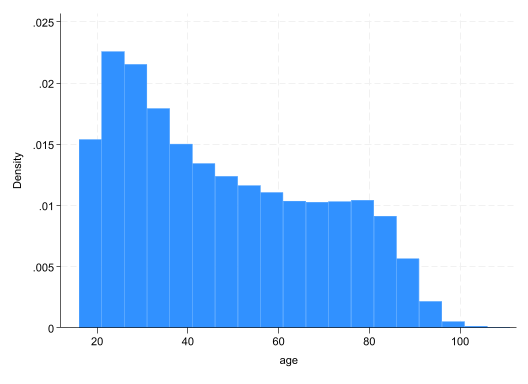

In [4]:
histogram age, width(5)


This table holds one randomly selected diagnostic code found during the observation period. The table is truncated to only include diagnostic codes with a count of 10 or more.

In [5]:
set linesize 132
groups description , select(f >= 10) ord(h) table 


  +-------------------------------------------------------------------------------------------+
  |                                                     description   Freq.   Percent     %<= |
  |-------------------------------------------------------------------------------------------|
  |                                                          asthma    5427     16.68   16.68 |
  |                                            Asthma annual review    3717     11.42   28.10 |
  |                                            asthma annual review    1721      5.29   33.39 |
  |                                  Asthma not limiting activities    1704      5.24   38.63 |
  |                                        Asthma medication review    1106      3.40   42.03 |
  |-------------------------------------------------------------------------------------------|
  |                                          Exacerbation of asthma    1069      3.29   45.31 |
  |                            Asthma n

These tables holds one randomly selected prescrption during the observation period. The table is truncated to only include codes with a count of 10 or more.


In [6]:
set linesize 132
groups bnf_code , select(f >= 10) ord(h) table 


  +----------------------------------------------------------+
  |                      bnf_code   Freq.   Percent      %<= |
  |----------------------------------------------------------|
  |        Adrenoreceptor agonist   39308     60.29    60.29 |
  |               Corticosteroids   17846     27.37    87.66 |
  | Antimuscarinic Bronchodilator    3581      5.49    93.15 |
  |                       Devices    2364      3.63    96.77 |
  |       Compound bronchodilator     945      1.45    98.22 |
  |----------------------------------------------------------|
  |                 Other/unknown     683      1.05    99.27 |
  |                  Theophylline     384      0.59    99.86 |
  |   Topical nasal decongestance      91      0.14   100.00 |
  +----------------------------------------------------------+


### Results
#### Overall

In [7]:
diagt diag test


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    31,083      1,457 |    32,540 
    Normal |    34,119    358,341 |   392,460 
-----------+----------------------+----------
     Total |    65,202    359,798 |   425,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.7%      7.6%       7.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.5%     95.3%     95.7%
Specificity                      Pr(-|N)     91.3%     91.2%     91.4%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.99     10.

#### Males

In [8]:
diagt diag test if sex==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    12,978        679 |    13,657 
    Normal |    15,709    178,919 |   194,628 
-----------+----------------------+----------
     Total |    28,687    179,598 |   208,285 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.6%      6.5%       6.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.0%     94.7%     95.4%
Specificity                      Pr(-|N)     91.9%     91.8%     92.0%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.77     11.

#### Females

In [9]:
diagt diag test if sex==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    18,105        778 |    18,883 
    Normal |    18,409    179,414 |   197,823 
-----------+----------------------+----------
     Total |    36,514    180,192 |   216,706 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.7%      8.6%       8.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.9%     95.6%     96.2%
Specificity                      Pr(-|N)     90.7%     90.6%     90.8%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.30     10.

#### Age
*16-29*

In [10]:
diagt diag test if agecat==16


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,859        506 |     7,365 
    Normal |     5,291    105,018 |   110,309 
-----------+----------------------+----------
     Total |    12,150    105,524 |   117,674 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.3%      6.1%       6.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.1%     92.5%     93.7%
Specificity                      Pr(-|N)     95.2%     95.1%     95.3%
ROC area               (Sens. + Spec.)/2      0.94      0.94      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     19.42     18.

*30-69*

In [11]:
diagt diag test if agecat==30


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    17,027        666 |    17,693 
    Normal |    16,502    187,200 |   203,702 
-----------+----------------------+----------
     Total |    33,529    187,866 |   221,395 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.0%      7.9%       8.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.2%     95.9%     96.5%
Specificity                      Pr(-|N)     91.9%     91.8%     92.0%
ROC area               (Sens. + Spec.)/2      0.94      0.94      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.88     11.

In [12]:
diagt diag test if agecat==70


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,197        285 |     7,482 
    Normal |    12,326     66,123 |    78,449 
-----------+----------------------+----------
     Total |    19,523     66,408 |    85,931 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.7%      8.5%       8.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.2%     95.7%     96.6%
Specificity                      Pr(-|N)     84.3%     84.0%     84.5%
ROC area               (Sens. + Spec.)/2      0.90      0.90      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.12      6.

#### Year at start of oberservation period 
*2004-2009*

In [13]:
diagt diag test if yearcat==2004


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    11,577        538 |    12,115 
    Normal |    12,797    125,088 |   137,885 
-----------+----------------------+----------
     Total |    24,374    125,626 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.1%      7.9%       8.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.6%     95.2%     95.9%
Specificity                      Pr(-|N)     90.7%     90.6%     90.9%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.30     10.

*2010-2015*

In [14]:
diagt diag test if yearcat==2010


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    10,763        536 |    11,299 
    Normal |    12,325    126,376 |   138,701 
-----------+----------------------+----------
     Total |    23,088    126,912 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.5%      7.4%       7.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.3%     94.8%     95.6%
Specificity                      Pr(-|N)     91.1%     91.0%     91.3%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.72     10.

*2016-2020*

In [15]:
diagt diag test if yearcat==2016


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     8,743        383 |     9,126 
    Normal |     8,997    106,877 |   115,874 
-----------+----------------------+----------
     Total |    17,740    107,260 |   125,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.3%      7.2%       7.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.8%     95.4%     96.2%
Specificity                      Pr(-|N)     92.2%     92.1%     92.4%
ROC area               (Sens. + Spec.)/2      0.94      0.94      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     12.34     12.

#### IMD of practice
*1-3*

In [16]:
diagt diag test if imdcat==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    10,903        584 |    11,487 
    Normal |    12,906    130,158 |   143,064 
-----------+----------------------+----------
     Total |    23,809    130,742 |   154,551 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.4%      7.3%       7.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.9%     94.5%     95.3%
Specificity                      Pr(-|N)     91.0%     90.8%     91.1%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.52     10.

*4-7*

In [17]:
diagt diag test if imdcat==4


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    11,099        443 |    11,542 
    Normal |    11,724    119,779 |   131,503 
-----------+----------------------+----------
     Total |    22,823    120,222 |   143,045 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.1%      7.9%       8.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.2%     95.8%     96.5%
Specificity                      Pr(-|N)     91.1%     90.9%     91.2%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.79     10.

*8-10*

In [18]:
diagt diag test if imdcat==8


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     8,955        422 |     9,377 
    Normal |     9,394    106,044 |   115,438 
-----------+----------------------+----------
     Total |    18,349    106,466 |   124,815 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.5%      7.4%       7.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.5%     95.1%     95.9%
Specificity                      Pr(-|N)     91.9%     91.7%     92.0%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.74     11.

#### Commissioning Regions
EAST OF ENGLAND

In [19]:
diagt diag test if regexm(region_name,"ENGLAND")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,241        325 |     7,566 
    Normal |     8,077     73,994 |    82,071 
-----------+----------------------+----------
     Total |    15,318     74,319 |    89,637 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.4%      8.3%       8.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.7%     95.2%     96.2%
Specificity                      Pr(-|N)     90.2%     90.0%     90.4%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.72      9.

London

In [20]:
diagt diag test if regexm(region_name,"LONDON")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       976         65 |     1,041 
    Normal |       843     14,841 |    15,684 
-----------+----------------------+----------
     Total |     1,819     14,906 |    16,725 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.2%      5.9%       6.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.8%     92.1%     95.1%
Specificity                      Pr(-|N)     94.6%     94.3%     95.0%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     17.44     16.

Midlands

In [21]:
diagt diag test if regexm(region_name,"MID")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,833        182 |     4,015 
    Normal |     4,343     38,185 |    42,528 
-----------+----------------------+----------
     Total |     8,176     38,367 |    46,543 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.6%      8.4%       8.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.5%     94.8%     96.1%
Specificity                      Pr(-|N)     89.8%     89.5%     90.1%
ROC area               (Sens. + Spec.)/2      0.93      0.92      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.35      9.

Yorkshire

In [22]:
diagt diag test if regexm(region_name,"YORK")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,099        222 |     6,321 
    Normal |     7,030     72,760 |    79,790 
-----------+----------------------+----------
     Total |    13,129     72,982 |    86,111 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.3%      7.2%       7.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.5%     96.0%     96.9%
Specificity                      Pr(-|N)     91.2%     91.0%     91.4%
ROC area               (Sens. + Spec.)/2      0.94      0.94      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.95     10.

North West

In [23]:
diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,438        194 |     3,632 
    Normal |     3,514     40,447 |    43,961 
-----------+----------------------+----------
     Total |     6,952     40,641 |    47,593 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.6%      7.4%       7.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.7%     93.9%     95.4%
Specificity                      Pr(-|N)     92.0%     91.7%     92.3%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.84     11.

South East

In [24]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,816        282 |     6,098 
    Normal |     6,358     78,029 |    84,387 
-----------+----------------------+----------
     Total |    12,174     78,311 |    90,485 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.7%      6.6%       6.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.4%     94.8%     95.9%
Specificity                      Pr(-|N)     92.5%     92.3%     92.6%
ROC area               (Sens. + Spec.)/2      0.94      0.94      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     12.66     12.

South West

In [25]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,819        130 |     2,949 
    Normal |     3,065     30,162 |    33,227 
-----------+----------------------+----------
     Total |     5,884     30,292 |    36,176 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.2%      7.9%       8.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.6%     94.8%     96.3%
Specificity                      Pr(-|N)     90.8%     90.5%     91.1%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.36     10.

#### System
SystmOne

In [26]:
diagt diag test if regexm(system,"One")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    17,324        693 |    18,017 
    Normal |    20,045    190,693 |   210,738 
-----------+----------------------+----------
     Total |    37,369    191,386 |   228,755 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.9%      7.8%       8.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.2%     95.9%     96.4%
Specificity                      Pr(-|N)     90.5%     90.4%     90.6%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     10.11      9.

Vision

In [27]:
diagt diag test if regexm(system,"Vision")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,049         57 |     1,106 
    Normal |     1,084     11,554 |    12,638 
-----------+----------------------+----------
     Total |     2,133     11,611 |    13,744 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.0%      7.6%       8.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.8%     93.4%     96.1%
Specificity                      Pr(-|N)     91.4%     90.9%     91.9%
ROC area               (Sens. + Spec.)/2      0.93      0.92      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.06     10.

EMIS

In [28]:
diagt diag test if regexm(ustrupper(system),"EMIS")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    12,656        705 |    13,361 
    Normal |    12,970    156,034 |   169,004 
-----------+----------------------+----------
     Total |    25,626    156,739 |   182,365 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.3%      7.2%       7.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.7%     94.3%     95.1%
Specificity                      Pr(-|N)     92.3%     92.2%     92.5%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     12.34     12.

#### RA_Index
Index==1

In [29]:
diagt diag test if RA_index==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    23,019      1,152 |    24,171 
    Normal |    24,766    272,760 |   297,526 
-----------+----------------------+----------
     Total |    47,785    273,912 |   321,697 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      7.5%      7.4%       7.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.2%     95.0%     95.5%
Specificity                      Pr(-|N)     91.7%     91.6%     91.8%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.44     11.

Index==0

In [30]:
diagt diag test if RA_index==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     8,064        305 |     8,369 
    Normal |     9,353     85,581 |    94,934 
-----------+----------------------+----------
     Total |    17,417     85,886 |   103,303 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      8.1%      7.9%       8.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.4%     95.9%     96.7%
Specificity                      Pr(-|N)     90.1%     90.0%     90.3%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.78      9.

#### Ethnicity
Ethnicity==0000white

In [31]:
diagt diag test if ethnicity=="0white"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    22,353        908 |    23,261 
    Normal |    23,804    210,916 |   234,720 
-----------+----------------------+----------
     Total |    46,157    211,824 |   257,981 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      9.0%      8.9%       9.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.1%     95.8%     96.3%
Specificity                      Pr(-|N)     89.9%     89.7%     90.0%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.48      9.

In [32]:
diagt diag test if ethnicity=="Other"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,481        181 |     2,662 
    Normal |     2,448     38,758 |    41,206 
-----------+----------------------+----------
     Total |     4,929     38,939 |    43,868 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.1%      5.8%       6.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.2%     92.2%     94.1%
Specificity                      Pr(-|N)     94.1%     93.8%     94.3%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     15.69     15.

In [33]:
diagt diag test if ethnicity=="Missing"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,249        368 |     6,617 
    Normal |     7,867    108,667 |   116,534 
-----------+----------------------+----------
     Total |    14,116    109,035 |   123,151 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.4%      5.2%       5.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.4%     93.9%     95.0%
Specificity                      Pr(-|N)     93.2%     93.1%     93.4%
ROC area               (Sens. + Spec.)/2      0.94      0.94      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     13.99     13.

In [34]:
tempname memhold
postfile `memhold' str20 var prev sens spec ppv npv roc using "validity.dta",replace

quietly diagt diag test
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("all") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Male") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Female") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==16
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age young") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==30
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age middle") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==70
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age elderly") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if yearcat==2004
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2004-2009") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if yearcat==2010
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2010-2015") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc')

quietly diagt diag test if yearcat==2016
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2016-2020") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if imdcat==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 1,3") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==4
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 4,7") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==8
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 8,10") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if regexm(region_name,"LONDON")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("London") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"MID")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Midlands") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"YORK")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Yorkshire") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("North West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South East") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"One")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("SystemOne") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"Vision")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Vision") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(ustrupper(system),"EMIS")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("EMIS") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex1") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex0") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="0white"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_0white") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="Other"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Other") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 



quietly diagt diag test if ethnicity=="Missing"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Missing") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

postclose `memhold'

### Logistic Regression
#### PPV

In [35]:
drop if missing(imdcat)
drop if missing(sex)

(2,589 observations deleted)
(9 observations deleted)


In [36]:
logistic diag_pos if test==1


Logistic regression                                     Number of obs = 64,980
                                                        LR chi2(0)    =   0.00
                                                        Prob > chi2   =      .
Log likelihood = -44968.344                             Pseudo R2     = 0.0000

------------------------------------------------------------------------------
    diag_pos |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   .9098845   .0071468   -12.02   0.000     .8959843    .9240003
------------------------------------------------------------------------------


In [37]:
logistic diag_pos i.bnf_code_values if test==1


Logistic regression                                    Number of obs =  64,980
                                                       LR chi2(7)    = 5136.45
                                                       Prob > chi2   =  0.0000
Log likelihood = -42400.118                            Pseudo R2     =  0.0571

------------------------------------------------------------------------------------------------
                      diag_pos | Odds ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------------------------+----------------------------------------------------------------
               bnf_code_values |
Antimuscarinic Bronchodilator  |   .4206788   .0171177   -21.28   0.000     .3884317    .4556031
      Compound bronchodilator  |   .4104671   .0319222   -11.45   0.000     .3524359    .4780536
              Corticosteroids  |    2.94211   .0561817    56.51   0.000     2.834031    3.054311
                      Devices  |   .5438071   .0253798   -13.05   0

In [38]:
gen newdiag=diag_pos

melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model1


Fitting fixed-effects model:

Iteration 0:  Log likelihood =  -44002.46  
Iteration 1:  Log likelihood = -43972.069  
Iteration 2:  Log likelihood = -43972.062  
Iteration 3:  Log likelihood = -43972.062  

Refining starting values:

Grid node 0:  Log likelihood = -43945.259

Fitting full model:

Iteration 0:  Log likelihood = -43945.259  (not concave)
Iteration 1:  Log likelihood = -43767.672  
Iteration 2:  Log likelihood = -43759.427  
Iteration 3:  Log likelihood = -43758.123  
Iteration 4:  Log likelihood = -43758.106  
Iteration 5:  Log likelihood = -43758.106  

Mixed-effects logistic regression               Number of obs     =     64,794
Group variable: practice_id                     Number of groups  =        332

                                                Obs per group:
                                                              min =          1
                                                              avg =      195.2
                                           

##### Likelihood ratio tests

In [39]:


quietly: melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic if test==1 || practice_id:,or
estimates store model_imd

quietly:melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.imdcat if test==1 || practice_id:,or
estimates store model_ethnicity

quietly:melogit newdiag i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_sex

quietly:melogit newdiag i.sex i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_year

quietly: melogit newdiag i.sex i.yearcat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_age



In [40]:
lrtest model1 model_sex
lrtest model1 model_year
lrtest model1 model_age
lrtest model1 model_ethnicity
lrtest model1 model_imd



Likelihood-ratio test
Assumption: model_sex nested within model1

 LR chi2(1) = 104.64
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_year nested within model1

 LR chi2(2) =  41.38
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_age nested within model1

 LR chi2(2) = 1337.26
Prob > chi2 =  0.0000

Likelihood-ratio test
Assumption: model_ethnic~y nested within model1

 LR chi2(2) =  90.96
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_imd nested within model1

 LR chi2(2) =  10.30
Prob > chi2 = 0.0058


#### NPV

In [41]:
logistic diag_neg if test==0


Logistic regression                                    Number of obs = 357,422
                                                       LR chi2(0)    =    0.00
                                                       Prob > chi2   =       .
Log likelihood = -9427.2139                            Pseudo R2     =  0.0000

------------------------------------------------------------------------------
    diag_neg |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |    245.668   6.466907   209.09   0.000     233.3146    258.6756
------------------------------------------------------------------------------


In [42]:
/* need to use the same response variable (newdiag) to line up the two model results */
replace newdiag=diag_neg 

melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2

(422,402 real changes made)

Fitting fixed-effects model:

Iteration 0:  Log likelihood = -34082.723  
Iteration 1:  Log likelihood = -9369.6961  
Iteration 2:  Log likelihood = -9301.2292  
Iteration 3:  Log likelihood = -9300.2337  
Iteration 4:  Log likelihood = -9300.2331  

Refining starting values:

Grid node 0:  Log likelihood = -8805.8374

Fitting full model:

Iteration 0:  Log likelihood = -8805.8374  
Iteration 1:  Log likelihood = -8793.7334  
Iteration 2:  Log likelihood = -8787.8168  
Iteration 3:  Log likelihood = -8785.9974  
Iteration 4:  Log likelihood = -8785.9887  
Iteration 5:  Log likelihood = -8785.9887  

Mixed-effects logistic regression               Number of obs     =    356,639
Group variable: practice_id                     Number of groups  =        336

                                                Obs per group:
                                                              min =          1
                                                              a

##### Likelihood ratio tests

In [43]:

quietly: melogit newdiag i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_sex
quietly: melogit newdiag i.sex i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_year
quietly: melogit newdiag i.sex i.yearcat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_age
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.imdcat if test==0 || practice_id:,or
estimates store model2_ethnicity
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic if test==0 || practice_id:,or
estimates store model2_imd


In [44]:
lrtest model2 model2_sex
lrtest model2 model2_year
lrtest model2 model2_age
lrtest model2 model2_ethnicity
lrtest model2 model2_imd



Likelihood-ratio test
Assumption: model2_sex nested within model2

 LR chi2(1) =   3.03
Prob > chi2 = 0.0818

Likelihood-ratio test
Assumption: model2_year nested within model2

 LR chi2(2) =  19.91
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_age nested within model2

 LR chi2(2) =  38.23
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_ethni~y nested within model2

 LR chi2(2) =  25.78
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_imd nested within model2

 LR chi2(2) =   0.53
Prob > chi2 = 0.7686


In [45]:
etable, estimates(model1 model2) showstars showstarsnote title("Table 2. PPV (1) and NPV (2),  OR, Random effect") cstat(_r_b,nformat(%6.2f)) column(index) export(validity2.xlsx, modify sheet(reg_asthma, replace))


Table 2. PPV (1) and NPV (2), OR, Random effect
------------------------------------------------------------------
                                                    1        2    
------------------------------------------------------------------
sex_coded                                                         
  1                                              0.85 **   1.10   
yearcat                                                           
  2010-2015                                      0.88 **   1.13   
  2016-2020                                      0.94 **   1.39 **
agecat                                                            
  0Middle                                        0.81 **   1.46 **
  Elderly                                        0.45 **   1.16   
region                                                            
  LONDON COMMISSIONING REGION                    1.14      0.81   
  MIDLANDS COMMISSIONING REGION                  1.06      0.87   
  NORTH EAST 

### Summary of validation parameters

In [46]:
use validity.dta, clear
replace prev=round(prev, 0.1)
gen prev_a=round(((prev/100)*((sens/100)+(spec/100)-1)+1-(spec/100))*100,0.1)/*apparent prevalence*/
replace sens=round(sens, 0.1)
replace spec=round(spec,0.1)
replace ppv=round(ppv, 0.1)
replace npv=round(npv, 0.1)
replace roc=round(roc, 0.01)


(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)


In [47]:
%head 50

,var,prev,sens,spec,ppv,npv,roc,prev_a
1,all,7.7,95.5,91.3,47.7,99.6,.93,15.4
2,Male,6.6,95,91.9,45.2,99.6,.93,13.8
3,Female,8.7,95.9,90.7,49.6,99.6,.93,16.8
4,Age young,6.3,93.1,95.2,56.5,99.5,.94,10.4
5,Age middle,8,96.2,91.9,50.8,99.6,.94,15.2
6,Age elderly,8.7,96.2,84.3,36.9,99.6,.9,22.7
7,Year 2004-2009,8.1,95.6,90.7,47.5,99.6,.93,16.3
8,Year 2010-2015,7.5,95.3,91.1,46.6,99.6,.93,15.4
9,Year 2016-2020,7.3,95.8,92.2,49.3,99.6,.94,14.2
10,"IMD 1,3",7.4,94.9,91,45.8,99.6,.93,15.4


In [48]:
/*texsave * using test3.tex, varlabels*/
export excel using  validity2.xlsx, sheet(val_asthma, replace)

file validity2.xlsx saved
